In [226]:
#Importing modules
# from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

from tqdm import tqdm

In [106]:
# 완벽한 실험 재현성을 위한 랜덤제어
random_seed = 28
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [2]:
dataset_path = 'C:/Users/ANDlab3/Desktop/paper/fashion-dataset/'
path = 'C:/Users/ANDlab3/Desktop/paper/fashion-dataset/images/'

In [3]:
print(os.listdir(dataset_path))

['data', 'images', 'images.csv', 'styles', 'styles.csv']


In [4]:
df = pd.read_csv(dataset_path + "styles.csv", nrows=44416, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df[['articleType','productDisplayName','image']]
df = df.reset_index(drop=True)

C:\Users\ANDlab3\anaconda3\envs\GAN\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33

In [5]:
df

,articleType,productDisplayName,image
0,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg
1,Jeans,Peter England Men Party Blue Jeans,39386.jpg
2,Watches,Titan Women Silver Watch,59263.jpg
3,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg
4,Tshirts,Puma Men Grey T-shirt,53759.jpg
...,...,...,...
44411,Heels,Catwalk Women Gold Flats,33091.jpg
44412,Tshirts,Kipsta Men Loose Fit Round Neck Jersey Red,1644.jpg
44413,Watches,Titan Women White Dial Watch NB9701WM01,40563.jpg
44414,Tshirts,Nike Men Striped Black Jersey,30614.jpg


In [6]:
temp=pd.DataFrame(df.articleType.value_counts())
temp=temp.reset_index()
df = pd.merge(df, temp, left_on='articleType', right_on='index', how='left')
del df['index']
df

,articleType_x,productDisplayName,image,articleType_y
0,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg,3217
1,Jeans,Peter England Men Party Blue Jeans,39386.jpg,609
2,Watches,Titan Women Silver Watch,59263.jpg,2541
3,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg,304
4,Tshirts,Puma Men Grey T-shirt,53759.jpg,7065
...,...,...,...,...
44411,Heels,Catwalk Women Gold Flats,33091.jpg,1323
44412,Tshirts,Kipsta Men Loose Fit Round Neck Jersey Red,1644.jpg,7065
44413,Watches,Titan Women White Dial Watch NB9701WM01,40563.jpg,2541
44414,Tshirts,Nike Men Striped Black Jersey,30614.jpg,7065


In [7]:
N_Pictures = 250
df = df[df['articleType_y'] > N_Pictures]
df

,articleType_x,productDisplayName,image,articleType_y
0,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg,3217
1,Jeans,Peter England Men Party Blue Jeans,39386.jpg,609
2,Watches,Titan Women Silver Watch,59263.jpg,2541
3,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg,304
4,Tshirts,Puma Men Grey T-shirt,53759.jpg,7065
...,...,...,...,...
44411,Heels,Catwalk Women Gold Flats,33091.jpg,1323
44412,Tshirts,Kipsta Men Loose Fit Round Neck Jersey Red,1644.jpg,7065
44413,Watches,Titan Women White Dial Watch NB9701WM01,40563.jpg,2541
44414,Tshirts,Nike Men Striped Black Jersey,30614.jpg,7065


In [8]:
N_Pictures = 250
N_Classes = np.sum(df.articleType_x.value_counts().to_numpy() > N_Pictures)
#Number of classes with sufficient images to train on:
N_Classes

37

In [9]:
#Inspecting the item classes that made it to our new dataset
temp = df.articleType_x.value_counts().sort_values(ascending=False)[:N_Classes]
temp[-5:]

Sweatshirts    285
Caps           283
Sweaters       277
Ties           263
Jackets        258
Name: articleType_x, dtype: int64

In [10]:
items_count = temp.values
items_label = temp.index.tolist()

In [18]:
#Creating new dataframes for training/validation
df_train = pd.DataFrame(columns=['articleType_x','image','productDisplayName'])
df_val   = pd.DataFrame(columns=['articleType_x','image','productDisplayName'])
df_test   = pd.DataFrame(columns=['articleType_x','image','productDisplayName'])

for ii in range(0,N_Classes):
    
    #print(items_label[ii])
    
    temp = df[df.articleType_x==items_label[ii]].sample(N_Pictures)

    df_train = pd.concat([df_train, temp[ :int(N_Pictures*0.7) ][['articleType_x','image','productDisplayName']] ]            , sort=False)
    df_val   = pd.concat([df_val,   temp[  int(N_Pictures*0.7): int(N_Pictures*0.8) ][['articleType_x','image','productDisplayName']] ], sort=False)
    df_test   = pd.concat([df_test,   temp[ int(N_Pictures*0.8): ][['articleType_x','image','productDisplayName']] ], sort=False)


df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

,articleType,image,productDisplayName
34516,Tshirts,25044.jpg,Nike Women Smash Pink T-shirt
29180,Tshirts,33937.jpg,ADIDAS Men Polo Black T-shirt
11923,Tshirts,42123.jpg,ADIDAS Men Navy Blue T-shirt
8420,Tshirts,21409.jpg,Locomotive Men Printed Grey T-shirt
15802,Tshirts,3055.jpg,Tantra Men's Right Now Green T-shirt
...,...,...,...
23240,Jackets,20208.jpg,Wrangler Women Solid Purple Jacket
21995,Jackets,17898.jpg,Nike Men Casual Grey Jacket
18680,Jackets,24845.jpg,Wildcraft Men Wind Cheaters Beige Jacket
13387,Jackets,38992.jpg,Gini and Jony Boys Rodeo Blue Jacket


In [26]:
df_train.rename(columns={'articleType_x': 'articleType'})

,articleType,image,productDisplayName
712,Tshirts,3991.jpg,Mr.Men Men's Wave Rider White T-shirt
27670,Tshirts,13423.jpg,United Colors of Benetton Men Solid Navy Blue ...
6561,Tshirts,7281.jpg,Batman Men's The Dark Knight Light Grey T-shirt
24778,Tshirts,10854.jpg,Wrangler Men Green Polo T-shirt
35518,Tshirts,35876.jpg,Marvel Boys Comics Orange T-shirt
...,...,...,...
11421,Jackets,12808.jpg,Nike Men Zip Pocket Blue Jackets
31658,Jackets,59118.jpg,Just Natural Men Navy Blue Reversible Jacket
39500,Jackets,19331.jpg,United Colors of Benetton Women Solid Navy Blu...
16095,Jackets,4848.jpg,ADIDAS Men Revo Navy White Jacket


In [27]:
df_val.rename(columns={'articleType_x': 'articleType'})

,articleType,image,productDisplayName
41643,Tshirts,52065.jpg,Myntra Men Blue T-shirt
12184,Tshirts,8412.jpg,ADIDAS Men Blue Polo Tshirts
34546,Tshirts,41959.jpg,Gini and Jony Boys Rugby Green T-shirt
27206,Tshirts,54926.jpg,Do u speak green Men Beige T-shirt
3420,Tshirts,27849.jpg,Scullers For Her Red Polo T-shirt
...,...,...,...
26398,Jackets,17628.jpg,ADIDAS Men Solid Grey Jacket
31551,Jackets,17900.jpg,Nike Men Football Soccer Red Jacket
5312,Jackets,15322.jpg,Nike Men Solid Black Jacket
29470,Jackets,15630.jpg,Nike Men AS Thermal Black Jackets


In [28]:
df_test.rename(columns={'articleType_x': 'articleType'})

,articleType,image,productDisplayName
34516,Tshirts,25044.jpg,Nike Women Smash Pink T-shirt
29180,Tshirts,33937.jpg,ADIDAS Men Polo Black T-shirt
11923,Tshirts,42123.jpg,ADIDAS Men Navy Blue T-shirt
8420,Tshirts,21409.jpg,Locomotive Men Printed Grey T-shirt
15802,Tshirts,3055.jpg,Tantra Men's Right Now Green T-shirt
...,...,...,...
23240,Jackets,20208.jpg,Wrangler Women Solid Purple Jacket
21995,Jackets,17898.jpg,Nike Men Casual Grey Jacket
18680,Jackets,24845.jpg,Wildcraft Men Wind Cheaters Beige Jacket
13387,Jackets,38992.jpg,Gini and Jony Boys Rodeo Blue Jacket


In [44]:
# df_train.to_csv('./train.csv')
# df_val.to_csv('./val.csv')
# df_test.to_csv('./test.csv')

In [23]:
# os.mkdir('data')
# os.mkdir('data/train')
# os.mkdir('data/val')
# os.mkdir('data/test')
os.chdir('C:/Users/ANDlab3/Desktop/paper/fashion-dataset/')

In [31]:
data = {'train': df_train, 'val': df_val, 'test': df_test}

# ansave each individual image to the new directory
for x in ['train','val','test']:
    
    print(x)
    
    for label, file, name in data[x].values:

        try:
            img = Image.open(dataset_path+'images/'+file)
            print(img)
        except FileNotFoundError:
            # If file does not exist continue
#             continue
            break
            
        #Else save file to new directory  
        try:
            img.save('data/'+x+'/'+label+'/'+file) 

        except FileNotFoundError:
            #If folder does not exist, create one and save the image
            os.mkdir('data/'+x+'/'+label)
            img.save('data/'+x+'/'+label+'/'+file)
            print(label,end=' ')

train
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284EA3E4790>
Tshirts <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECEE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECC70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECD90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECC70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9EECFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECEE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EECF10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9EDA130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA250>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDAB50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDADC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9EDA400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9EDADC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9EDA130>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9EDA400>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED47C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED4EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED47C0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED27F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED2FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED27F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED2FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED27F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED2FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED27F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED2FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED19D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED1FD0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED0F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCFD60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCFD60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED0DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCFE20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED0820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9ED1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9ED0820>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCE460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCEEE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCF3D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCDD30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCDD60>
Watches <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCE460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCF3D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCE460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCDD60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCFFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCEEE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCE9

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCD670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCA100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCBA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCA100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCB430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCA100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCB430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCA3A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCA880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCA3A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCB430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCBF40>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC8EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC8A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC8CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC8CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC9790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCAC40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC9790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC9A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC8D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC9E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DCA3A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DCD0D0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC6E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC6E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC6E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC7F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x200 at 0x284E9DC79D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC6E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC7D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC76D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC9A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC6A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC6F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC6160>
<PIL.J

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC7D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC7C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC76D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC7F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC79D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC7D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5DF0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC53A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC53A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5F40>
Tops <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC53A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC31F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC5850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC3EB0>

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC5E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC3FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC4E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC3FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC3730>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC3C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0340>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFE50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0F70>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBF0A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0400>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF0A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFE50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF0A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEE0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFE50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC00D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC00D0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFDF0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFA60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0370>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBF820>
<PIL

Briefs <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC0400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC0340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFEB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC040

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFDF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DBFC10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBFC10>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1700>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1340>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1460>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1850>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL

Socks <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B20

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D90>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1700>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1970>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1970>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1970>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC11F0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1100>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DF0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
Flats <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x480 at 0x284E9DC1C70>
<PIL.J

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
Sarees <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC143

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D30>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A60>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1820>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1220>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1520>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1BB0>
val
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF9D0>
Tshirts <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1400>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
Sarees <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284EA0D58B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
Lipstick <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DBF9D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
Caps <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1190>

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1E20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC17C0>
test
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284EA0D58B0>
Tshirts <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC11F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC11F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x200 at 0x284E9DC11F0>
<PIL.J

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC11F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x1600 at 0x284E9DC1A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1220>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1DC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1BB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1640>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC17C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC12B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1040>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x200 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC13A0>
<PIL.J

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1040>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1CD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1280>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1880>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EE0>
Jeans <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1B50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1AF0

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1B80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FD0>
Trousers <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1730>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EB0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1850>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CD0>
Bra <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
Sarees <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC11F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BB

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC18B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1DF0>
Deodorant <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1910>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1BB0>
Lipstick <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1610>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1A60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
Clutches <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC16D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC15E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1F10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC10D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1CA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1370>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1EE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1D60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1EE0>
<PIL

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1220>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC12E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC13A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1AC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC14C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1430>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1190>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x2400 at 0x284E9DC1640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440 at 0x284E9DC1550>
<PIL

In [33]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

In [34]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6475
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 925
     Root location: data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1850
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                C

In [37]:
dataset_sizes

{'train': 6475, 'val': 925, 'test': 1850}

In [39]:
class_names

['Backpacks',
 'Belts',
 'Bra',
 'Briefs',
 'Caps',
 'Casual Shoes',
 'Clutches',
 'Deodorant',
 'Dresses',
 'Earrings',
 'Flats',
 'Flip Flops',
 'Formal Shoes',
 'Handbags',
 'Heels',
 'Jackets',
 'Jeans',
 'Kurtas',
 'Lipstick',
 'Nail Polish',
 'Perfume and Body Mist',
 'Sandals',
 'Sarees',
 'Shirts',
 'Shorts',
 'Socks',
 'Sports Shoes',
 'Sunglasses',
 'Sweaters',
 'Sweatshirts',
 'Ties',
 'Tops',
 'Track Pants',
 'Trousers',
 'Tshirts',
 'Wallets',
 'Watches']

In [40]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [41]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

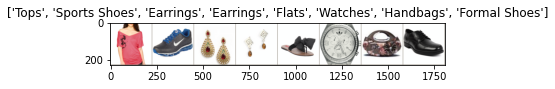

In [43]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# train_model_define

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

In [64]:
def visualize_model(model, mode, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    if mode == 'val':
        dataloader = dataloaders['val']
    elif mode == 'test':
        dataloader = dataloaders['test']

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning all param

In [56]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Changing the number of outputs in the last layer to the number of different item types
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [57]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
train Loss: 2.5467 Acc: 0.2531


 10%|█         | 1/10 [01:51<16:41, 111.30s/it]

val Loss: 1.6038 Acc: 0.4941

Epoch 1/9
----------
train Loss: 1.5177 Acc: 0.5025


 20%|██        | 2/10 [03:37<14:26, 108.25s/it]

val Loss: 1.0745 Acc: 0.6238

Epoch 2/9
----------
train Loss: 1.1502 Acc: 0.6130


 30%|███       | 3/10 [05:24<12:35, 107.86s/it]

val Loss: 1.1430 Acc: 0.6022

Epoch 3/9
----------
train Loss: 0.9482 Acc: 0.6744


 40%|████      | 4/10 [07:11<10:44, 107.36s/it]

val Loss: 0.9680 Acc: 0.7049

Epoch 4/9
----------
train Loss: 0.8133 Acc: 0.7206


 50%|█████     | 5/10 [08:57<08:55, 107.02s/it]

val Loss: 0.7007 Acc: 0.7395

Epoch 5/9
----------
train Loss: 0.7242 Acc: 0.7492


 60%|██████    | 6/10 [10:44<07:06, 106.75s/it]

val Loss: 0.6900 Acc: 0.7546

Epoch 6/9
----------
train Loss: 0.6505 Acc: 0.7771


 70%|███████   | 7/10 [12:30<05:19, 106.55s/it]

val Loss: 3.4734 Acc: 0.3373

Epoch 7/9
----------
train Loss: 0.4223 Acc: 0.8469


 80%|████████  | 8/10 [14:16<03:33, 106.51s/it]

val Loss: 0.4864 Acc: 0.8324

Epoch 8/9
----------
train Loss: 0.3741 Acc: 0.8635


 90%|█████████ | 9/10 [16:02<01:46, 106.44s/it]

val Loss: 0.4602 Acc: 0.8368

Epoch 9/9
----------
train Loss: 0.3393 Acc: 0.8783


100%|██████████| 10/10 [17:48<00:00, 106.88s/it]

val Loss: 0.4651 Acc: 0.8357

Training complete in 17m 49s
Best val Acc: 0.836757


In [59]:
SAVE_PATH = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/model/"
torch.save(model_ft.state_dict(), SAVE_PATH + 'model_fine_tuned.pt')

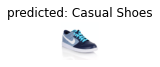

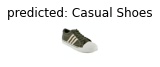

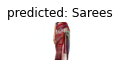

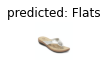

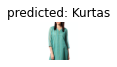

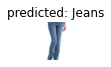

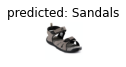

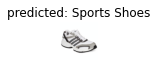

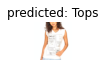

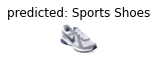

In [71]:
visualize_model(model_ft, 'val', 10)

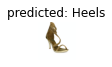

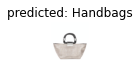

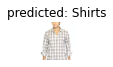

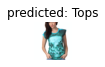

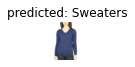

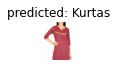

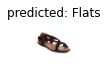

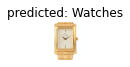

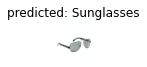

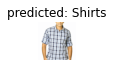

In [72]:
visualize_model(model_ft, 'test', 10)

In [80]:
load_path = 'C:/Users/ANDlab3/Desktop/paper/fashion-dataset/model/'

In [82]:
model_ft = model_ft.to(device) # 모델 선언
model_ft.load_state_dict(torch.load(load_path+'model_fine_tuned.pt')) # 모델 파라메타 불러오기

<All keys matched successfully>

In [ ]:
def visualize_model(model, mode, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    if mode == 'val':
        dataloader = dataloaders['val']
    elif mode == 'test':
        dataloader = dataloaders['test']

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [234]:
correct = 0
total = 0

true = []
pred = []

with torch.no_grad():
    model_ft.eval() #현재는 모델에 드랍아웃이나, 패딩이 없어서 필요없지만 만약 사용된 경우에는 eval을 통해서 평가시에는 꼭 비활성화 시켜야한다.
    f1_score = 0
    for data in dataloaders['test']:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs =  model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
  
        true += labels.cpu().numpy().tolist()
        pred += predicted.cpu().numpy().tolist()

print('done')

done


In [236]:
# confusion = confusion_matrix(true, pred)
accuracy = accuracy_score(true, pred)
# precision = precision_score(true, pred, average='weighted')
# recall = recall_score(true, pred, average='weighted')       

precision = precision_score(true, pred, average='micro')
recall = recall_score(true, pred, average='micro')   
# f1_score = f1_score(true, pred, average='macro')
        
print('전체 데이터 수 : ', total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print('정확도:{0:0.5f}%, 정밀도:{0:0.5f}%, 재현율:{0:0.5f}%'.format(accuracy*100, precision*100, recall*100))
print(f1_score)

# print('Confusion Matrix')
# print(confusion)

전체 데이터 수 :  1850
Accuracy of the network on the 10000 test images: 85 %
정확도:85.35135%, 정밀도:85.35135%, 재현율:85.35135%
0


In [244]:
# Classification Report 저장
CL_REPORT_FILE = "./cl_report.csv"

cl_report = classification_report(true, pred, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score   support
0                 0.873   0.960     0.914    50.000
1                 1.000   0.980     0.990    50.000
2                 1.000   1.000     1.000    50.000
3                 0.980   0.980     0.980    50.000
4                 0.902   0.920     0.911    50.000
5                 0.743   0.520     0.612    50.000
6                 0.811   0.860     0.835    50.000
7                 0.852   0.920     0.885    50.000
8                 0.814   0.700     0.753    50.000
9                 1.000   0.960     0.980    50.000
10                0.553   0.840     0.667    50.000
11                0.849   0.900     0.874    50.000
12                0.714   1.000     0.833    50.000
13                0.975   0.780     0.867    50.000
14                0.769   0.400     0.526    50.000
15                0.756   0.620     0.681    50.000
16                0.839   0.940     0.887    50.000
17                0.729   0.860     0.789    50.000
18          